# Background
    The purpose of this notebook is to extract from the liar dataset [https://www.cs.ucsb.edu/~william/data/liar_dataset.zip] the 15 features out of the feature list in the paper [https://arxiv.org/pdf/1812.00315.pdf], and train models on the datasets, and analyze the efficacy of different features with multiple ML models.
    The following codes are written based on online forum, public repositories, and with help from project team member.
    Notably, many feature extraction techniques are based on repository: [https://github.com/nishitpatel01/Fake_News_Detection]

# 15 features  to extract and train:
- Quantity
    - Character count
    - Word count
    - Sentence count
    - Paragraph count
- Complexity
    - Average number of characters per word
    - Average number of punctuations per sentence
- Uncertainty
    - Percentage of certainty terms
    - Percentage of generalizing terms
    - Percentage of numbers and quantifiers
- Subjectivity
    - Percentage of imperative commands
- Non-immediacy
    - Percentage of rhetorical questions
- Sentiment
    - Number of exclamation marks
- Diversity
    - Content word diversity: unique content words (%)
- Informality
    - Typographical error ratio: misspelled words (%)
- Specificity
    - Temporal ratio
    

# library and dataset import

In [17]:
import numpy as np
import pandas as pd
import csv

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import sent_tokenize

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

from sklearn.ensemble import RandomForestRegressor #random forest model family
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier # KNN model

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import re
from collections import Counter

import seaborn as sb
from yellowbrick.classifier import ClassificationReport

#dataset import
headernames = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker_job', 'state', 'party', 'barely true', 'false', 'half true', 'mostly ture', 'pants on fire', 'context']
train_data = pd.read_csv('./train.tsv', delimiter = '\t', names = headernames)
test_data = pd.read_csv('./test.tsv', delimiter = '\t', names = headernames)
valid_data = pd.read_csv('./valid.tsv', delimiter = '\t', names = headernames)

#display image in notebook
from IPython.display import Image
from IPython.core.display import HTML 

#to display multiple outputs per cell, not just the last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data exploration

In [18]:
train_data.shape #(number of samples, number of features)
test_data.shape
valid_data.shape

(10240, 14)

(1267, 14)

(1284, 14)

In [19]:
train_data.head(n=1)
test_data.head(n=1)
valid_data.head(n=1)
train_data.dtypes
train_data.describe()  #analytical attributes of features

,ID,label,statement,subject,speaker,speaker_job,state,party,barely true,false,half true,mostly ture,pants on fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer


,ID,label,statement,subject,speaker,speaker_job,state,party,barely true,false,half true,mostly ture,pants on fire,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview


,ID,label,statement,subject,speaker,speaker_job,state,party,barely true,false,half true,mostly ture,pants on fire,context
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News


ID                object
label             object
statement         object
subject           object
speaker           object
speaker_job       object
state             object
party             object
barely true      float64
false            float64
half true        float64
mostly ture      float64
pants on fire    float64
context           object
dtype: object

,barely true,false,half true,mostly ture,pants on fire
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407
std,18.973764,24.112936,35.846511,36.151688,16.128927
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


# Data cleaning
Isolating the statement needed for feature extraction, and the label of fake/not fake

In [20]:
#prepare text for feature extraction
train_statement = train_data["statement"]
test_statement = test_data["statement"]
valid_statement = valid_data["statement"]
#dividing news accuracy labels into fake/not fake from original categorization, for training, testing, and valid datasets
train_label = train_data["label"]
train_label = train_label.replace("true","Not Fake")
train_label = train_label.replace("half-true", "Not Fake")
train_label = train_label.replace("mostly-true", "Not Fake")
train_label = train_label.replace("false","Fake")
train_label = train_label.replace("pants-fire","Fake")
train_label = train_label.replace("barely-true","Fake")

test_label = test_data["label"]
test_label = test_label.replace("true","Not Fake")
test_label = test_label.replace("half-true", "Not Fake")
test_label = test_label.replace("mostly-true", "Not Fake")
test_label = test_label.replace("false","Fake")
test_label = test_label.replace("pants-fire","Fake")
test_label = test_label.replace("barely-true","Fake")

valid_label = valid_data["label"]
valid_label = valid_label.replace("true","Not Fake")
valid_label = valid_label.replace("half-true", "Not Fake")
valid_label = valid_label.replace("mostly-true", "Not Fake")
valid_label = valid_label.replace("false","Fake")
valid_label = valid_label.replace("pants-fire","Fake")
valid_label = valid_label.replace("barely-true","Fake")

# Feature extraction
For each statement in dataset, define the methods to extract the 15 features listed

In [21]:
vectorizer = CountVectorizer()
train_count = vectorizer.fit_transform(train_data["statement"].values)

#stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

#POS-tagging
def tagging(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text)
    return tagged

#Complexity
#1.character count
def count_char(str):
    char = RegexpTokenizer(r'\w+').tokenize(str)
    return len(char)
#2.word count
def count_word(str):
    word = word_tokenize(str)
    return len(word)
#3.sentence count
def count_sentence(str):
    sentence = sent_tokenize(str)
    return sentence
#4.paragraph count
#since text data is a statement, and there is no systematic way of knowing where a paragraph ends,
#this feature is not viable for this project

#Complexity
#5.average number of character per word
def avg_char_per_word(str):
    word = word_tokenize(str)
    for element in word:
        char = RegexpTokenizer(r'\w+').tokenize(element)
        charCount += len(char)
    avg = charCount/len(word)
    return avg

#6.average number of punctuation per sentence
def avg_punc_per_sent(str):
    word = word_tokenize(str)
    wordPunc = WordPunctTokenizer().tokenize(str)
    sentence = sent_tokenize(str)
    avg = (len(wordPunc)-len(word))/len(sentence)
    return avg

#Uncertainty
#7.percentage of certainty terms

#8.percentage of gerneralizing terms

#9.percentage of numbers and quantifiers

#Subjectivity
#10.percentage of imperative commands

#Non-immediacy
#11.percentage of rhetorical questions
#cannot find related libary for rhetorical questions, don't know how to identify rhetoical questions

#Sentiment
#12.number of exclamation mark
def count_excl(str):
    count = str.count("!")
    return count

#Diversity
#13.content word diversity: unique content words (%)
def unique_words(str):
    word_t = word_tokenize(str)
    unique_words=[word for word in word_t if word not in unique_words]
    percentage = len(unique_words)/len(word_t)
    return percentage


#Informality
#14.Typographical error ratio: misspelled words (%)
def count_typo(tag):
    if(tag == "X"):
        typo += 1
    return typo

#Specificity
#15.Temporal ratio


In [22]:
#Complexity
#1.character count
char_count = []

#2.word count
word_count = []
#3.sentence count
sent_count = []
#4.paragraph count
#since text data is a statement, and there is no systematic way of knowing where a paragraph ends,
#this feature is not viable for this project

#Complexity
#5.average number of character per word
avg_char_per_word_count = []
#6.average number of punctuation per sentence
avg_punc_per_sent_count = []
#Uncertainty
#7.percentage of certainty terms
percentage_certainty = []
#8.percentage of gerneralizing terms
percentage_generalizing = []
#9.percentage of numbers and quantifiers
percentage_numbers = []
#Subjectivity
#10.percentage of imperative commands

#Non-immediacy
#11.percentage of rhetorical questions
#cannot find related libary for rhetorical questions, don't know how to identify rhetoical questions

#Sentiment
#12.number of exclamation mark
excl_count = []
#Diversity
#13.content word diversity: unique content words (%)
unique_count = []
#Informality
#14.Typographical error ratio: misspelled words (%)
typo_count = []
#Specificity
#15.Temporal ratio
temporal_count = []

#for every statement in train_statement make a dataset with the extracted features
for statement in train_statement:
    char_count.append(count_char(statement))
    word_count.append(count_word(statement))
char_count_series = pd.Series(char_count)
word_count_series = pd.Series(word_count)
train_data_cleaned = pd.concat([train_statement, train_label, char_count_series, word_count_series], axis=1)
train_data_cleaned.rename(columns={'statement': 'statement', 'label': 'label', 0: 'char_count', 1: 'word_count'}, inplace=True)

#for every statement in test_statement make a dataset with the extracted features
char_count = [] #reset all lists 
for statement in test_statement:
    char_count.append(count_char(statement))
    word_count.append(count_word(statement))
char_count_series = pd.Series(char_count)
word_count_series = pd.Series(word_count)
test_data_cleaned = pd.concat([test_statement, test_label, char_count_series, word_count_series], axis=1)
test_data_cleaned.rename(columns={'statement': 'statement', 'label': 'label', 0: 'char_count', 1: 'word_count'}, inplace=True)

# Data preprocessing

In [23]:
LE = preprocessing.LabelEncoder()
#fake = 0, not fake = 1
train_data_cleaned['label'] = LE.fit_transform(train_data_cleaned['label'].astype(str))
test_data_cleaned['label'] = LE.fit_transform(test_data_cleaned['label'].astype(str))


# Model training

In [24]:
#image of machine learning model selection map
Image(url= "https://qph.fs.quoracdn.net/main-qimg-65e581f52fafa1cd6021a721e2ec1616")

In [25]:
cols = [col for col in train_data_cleaned.columns if col not in ['label', 'statement']]
print(cols)

['label', 'char_count']


In [26]:
X_train = train_data_cleaned[cols]
y_train = train_data_cleaned['label']
X_test = test_data_cleaned[cols]
y_test = test_data_cleaned['label']

In [27]:
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

In [28]:
#Naive Bayes
gnb = GaussianNB()
pred_nb = gnb.fit(X_train, y_train).predict(X_test)

# Model performance

ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001506260E848>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000015061DD8FC8>,
                     encoder=None, force_model=False, is_fitted='auto',
                     model=None, support=None)

C:\Users\mingj\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.11010689145737378

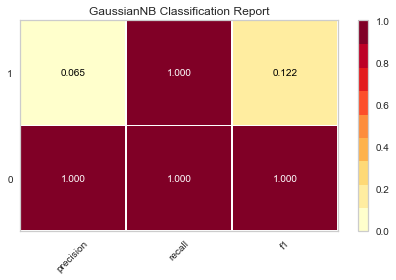

[[  553     0     0]
 [    0   714     0]
 [    0 10240     0]]


In [29]:
visualizer_nb = ClassificationReport(gnb)
visualizer_nb.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer_nb.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer_nb.poof() # Draw/show/poof the data

conf_matrix = confusion_matrix(y_test, pred_nb)
print(conf_matrix)